# Covid-19: From model prediction to model predictive control

## A demo of the stochastic modeling framework

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

Our code implements a SEIRS infectious disease dynamics models with extensions to model the effect quarantining detected cases. Using the concept of 'classes' in Python 3, the code was integrated with our previous work and allows to quickly perform Monte Carlo simulations, calibrate model parameters and calculate an *optimal* government policies using a model predictive controller (MPC). A white paper and souce code of our previous work can be found on the Biomath website. 

https://biomath.ugent.be/covid-19-outbreak-modelling-and-control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx
import models

#### General

The SEIR model was first proposed in 1929 by two Scottish scientists. It is a compartmental model that subdivides the human population in four types of people : 1) healthy individuals susceptible to the infectious disease, 2) exposed individuals in a latent phase (partially the incubation period), 3) infectious individuals able to transmit the disease and 4) individuals removed from the population either through immunisation or death. Despite being a simple and idealised reality, the SEIR model is used extensively to predict the outbreak of infectious diseases and this was no different during the outbreak in China earlier this year. In this work, we extended the SEIR model to incorporate more expert knowledge on SARS-Cov-2 into the model. The infectious pool is split into four parts. The first is a period of pre-symptomatic infectiousness. Several studies have shown that pre-symptomatic transmission is a dominant transmission mechanism of SARS-Cov-2. After the period of pre-symptomatic transmission, three possible infectious outcomes are modelled. 1) asymptomatic outcome, for patients who show no symptoms at all 2) mild outcome, for patients with mild symptoms, these patients recover at home 3) a mild infection can degress to the point where a hospitalision is needed. The pool of *recovered* individuals from the classical SEIR model is split into an recovered and dead pool. People from the susceptible, exposed, pre-symptomatic infectious, asymptomatic infectious, mild infectious and recovered pool can be quarantined after having tested positive for Covid-19. Note that for individuals in the susceptible and recovered pools, this corresponds to a *false positive* test. The dynamics of our extended SEIR model are presented in the flowchart below. We make the following assumptions with regard to the general SEIRS dynamics,

<img src="../figs/flowchartAll.jpg" alt="drawing" width="700"/>

We make the following assumptions with regard to the SEIRS dynamics,

1. There is no connection between the severity of the disease and the infectiousness of an individual. Only the duration of infectiousness can differ.
2. All patients experience a brief pre-symptomatic, infectious period.
3. All deaths come from intensive care units in hospitals, meaning no patients die outside a hospital. Of the 7703 diseased (01/05/2020), 46\% died in a hospital while 53\% died in an elderly home. All hospital deaths are confirmed Covid-19 cases while only 16\% of elderly home deaths were confirmed. When taking the elderly homes out of the model scope, the assumption that deaths only arise in hospitals is true due to the fact that only 0.3\% died at home and 0.4\% died someplace else. Asymptomatic and mild cases automatically lead to recovery and in no case to death (https://www.info-coronavirus.be/nl/news/trends-laatste-dagen-zetten-zich-door/).
4. We implement no testing and quarantining in the hospital. Hospitalised persons are assumed to be incapable of infecting susceptibles, so the implementation of a quarantine would not change the dynamics but slow down calculations.
5. Recovered patients are assumed to be immune, seasonality is deemed out of scope of this work.

#### Hospital subystem (preliminary)

The hospital subsystem is a simplification of actual hospital dynamics. The dynamics and estimated parameters were  obtained by interviewing Ghent University Hospital staff and presenting the resulting meeting notes to the remaining three Ghent hospitals for verification.

At the time of writing (30/04/2020) every admitted patient is tested for Covid-19. Roughly 10% of all Covid-19 patients at UZ Ghent originally came to the hospital for some other medical condition. The remaining 90% of all Covid-19 arrives in the emergency room or comes from hospitals in heavily struck regions. The fraction of people the hospital when getting infected with Covid-19 are reported to authorities as ‘new hospitalisations’. There are three hospital wards for Covid-19 patients: 1) Cohort, which should be seen like a regular hospital ward with Covid-19 patients. Patients are not monitored permanently in this ward. 2) Midcare, a ward where more severe cases are monitored more cosely than in Cohort. Midcare is more closely related to ICU than to Cohort and is usually lumped with the number of ICU patients when reporting to the officials. 3) Intensive care, for patients with the most severe symptoms. Intensive care needs can include the use of a ventilator to supply the patient with oxygen. It was noted that the fraction Cohort vs. Midcare and ICU is roughly 50-50%.

<img src="../figs/hospitalRealLife.jpg" alt="drawing" width="400"/>

Generally, patients can switch between any of the wards depending on how the disease progresses. However, some dominant *flows* exist. Usually, it is apparent upon a patients arrival to which ward he or she will be assigned. On average patients who don’t degress stay in Cohort for 6 days, with values spread between 3 and 8 days. The average ICU stay is 14 days when a patient doesn’t need ventilation. If the patient needs ventilation the stay is slightly longer. After being in ICU, patients return to Cohort for an another 6 to 7 days of recovery. Based on these dominant *flows*, the hospital subsystem was simplified by making the following assumptions,
1. Assume people arriving at the hospital are instantly distributed between Cohort, Midcare or ICU.
2. Merge ventilator and non-ventilator ICU.
3. Assume deaths can only arise in ICU.
4. Assume all patients in midcare and ICU pass via Cohort on their way to recovery.
5. Assume that the 10% of the patients that come from hospital actually come from the population.

### Deterministic vs. Stochastic framework

The extended SEIR model is implemented using two frameworks: a deterministic and a stochastic (network based) framework. **This Jupyter Notebooks is a demo of the deterministic model,** a demo of the stochastic network simulator is available in *SEIRSNetworkModel_Demo*. A deterministic implementation of the extended SEIRS model captures important features of infectious disease dynamics, but it assumes uniform mixing of the population (i.e. every individual in the population is equally likely to interact with every other individual). The deterministic approach results in a set of N ordinary differential equations, one for every of the N ’population pools’ considered. The main advantage of a deterministic model is that a low amount of computational resources are required while still maintaining an acceptable accuracy. The deterministic framework allows to rapidly explore scenarios and perform optimisations which require thousands of function evaluations. 

However, it is often important to consider the structure of contact networks when studying disease transmission and the effect of interventions such as social distancing and contact tracing. The main drawback of the deterministic approach is the inability to simulate contact tracing, which is one of the most promising measures against the spread of SARS-Cov-2. For this reason, the SEIRS dynamics depicted in on the above flowchart can be simulated on a Barabasi-Albert network. This advantages include a more detailed analysis of the relationship between social network structure and effective transmission rates, including the effect of network-based interventions such as social distancing, quarantining, and contact tracing. The added value comes at a high price in terms of computational resources. It is not possible to perform optimisations of parameters in the stochastic network model on a personal computer. Instead, high performance computing infrastructure is needed. The second drawback is the need for more data and/or assumptions on social interactions and how government measures affect these social interactions.

### Model parameters

In the above equations, S stands for susceptible, E for exposed, A for asymptomatic, M for mild, H for hospitalised, C for cohort, Mi for midcare, ICU for intensive care unit, D for dead, R for recovered. The quarantined states are denoted with a Q suffix, for instance AQ stands for asymptomatic and quarantined. The states S, E, A, M and R can be quarantined. The disease dynamics when quarantined are identical to the non quarantined dynamics. For instance, EQ will evolve into AQ or MQ with the same probability as E evolves into A or M. Individuals from the MQ pool can end up in the hospital. N stands for the total population. The clinical parameters are: a, m: the chance of having an asymptomatic or mild infection. h: the fraction of mildly infected which require hospitalisation. c: fraction of the hospitalised which remain in Cohort, mi: fraction of hospitalised which end up in midcare. Based on reported cases in China and travel data, Li et al. (2020b) estimated that 86 % of coronavirus infections in the country were "undocumented" in the weeks before officials instituted stringent quarantines. This figure thus includes the asymptomatic cases and an unknown number of mildly symptomatic cases and is thus an overestimation of the asymptotic fraction. In Iceland, citizens were invited for testing regardless of symptoms. Of all people with positive test results, 43% were asymptomatic (Gudbjartsson et al., 2020). The actual number of asymptomatic infections might be even higher since it seemed that symptomatic persons were more likely to respond to the invitation (Sciensano, 2020). In this work it is assumed that 43 % of all infected cases are asymptomatic. This figure can later be corrected in light of large scale immunity testing in the Belgian population. Hence,

$$ a = 0.43 .$$

Wu and McGoogan (2020) estimated that the distribution between mild, severe and critical cases is equal to 81%, 15% and 4%. As a rule of thumb, one can assume that one third of all hospitalised patients ends up in an ICU. Based on interviews with Ghent University hospital staff, midcare is merged with ICU in the offical numbers. For now, it is assumed that the distribution between midcare and ICU is 50-50 %. The sum of both pools is one third of the hospitalisations. Since the average time a patient spends in midcare is equal to ICU, this corresponds to seeing midcare and ICU as 'ICU'.

$\sigma$: length of the latent period. Assumed four days based on a modeling study by Davies et al. (2020) .

$\omega$: length of the pre-symptomatic infectious period, assumed 1.5 days (Davies et al. 2020). The sum of $\omega$ and $\sigma$ is the total incubation period, and is equal to 5.5 days. Several estimates of the incubation period have been published and range from 3.6 to 6.4 days, with the majority of estimates around 5 days (Park et. al 2020).

$d_{a}$ , $d_{m}$ , $d_{h}$ : the duration of infection in case of a asymptomatic or mild infection. Assumed to be 6.5 days. Toghether with the length of the pre-symptomatic infectious period, this accounts to a total of 8 days of infectiousness. 

$d_{c}$ , $d_{\text{mi}}$ , $d_{\text{ICU}}$: average length of a Cohort, Midcare and ICU stay. Equal to one week, two weeks and two weeks respectively.

$d_{\text{mi,recovery}}$ , $d_{\text{ICU,recovery}}$: lengths of recovery stays in Cohort after being in Midcare or IC. Equal to one week.

Zhou et al. (2020) performed a retrospective study on 191 Chinese hospital patients and determined that the time from illness onset to discharge or death was 22.0 days (18.0-25.0, IQR) and 18.5 days (15.0-22.0, IQR) for survivors and victims respectively. Using available preliminary data, the World Health Organisation estimated the median time from onset to clinical recovery for mild cases to be approximately 2 weeks and to be 3-6 weeks for patients with severe or critical disease (WHO, 2020). Based on this report, we assume a recovery time of three weeks for heavy infections.

$d_{hospital}$ : the time before heavily or critically infected patients reach the hospital. Assumed 5-9 days (Linton et al. 2020). Still waiting on hospital input here.

$m_0$ : the mortality in ICU, which is roughly 50\% (Wu and McGoogan, 2020). 

$\zeta$: can be used to model the effect of re-susceptibility and seasonality of a disease. Throughout this demo, we assume $\zeta = 0$ because data on seasonality is not yet available at the moment. We thus assume permanent immunity after recovering from the infection.

## Performing simulations

### Without age-structuring

#### The 'SEIRSNetworkModel' class

The *SEIRSNetworkModel* class uses the exact same class structure and function names as the *SEIRSAgeModel* deterministic class, which is detailed below.

<img src="../figs/SEIRSNetworkModel.jpg"
     alt="class"
     height="600" width="700"     
     style="float: left; margin-right: 500px;" /> 

As of now (20/04/2020), the SEIRSNetworkModel contains 5 functions which can be grouped in two parts: 1) functions to run and visualise simulations and 2) functions to perform parameter estimations and visualse the results. Implementing the model predictive controller is straightforward and can easily be done. However, the optimisation problem is really difficult and requires thousands of function evaluations. Given the large amount of computational resources required to run just one stochastic simulation, it is highly unlikely that the model predictive controller will ever be used to optimize government policy. The MPC functions will be implemented and their usefullness assessed after a calibration is performed. Also, scenario specific functions will be added over the course of next week. 

#### Creating a SEIRSNetworkModel object

Before a stochastic simulation can be performed, the interaction network G, which determines the connectivity of the network model, must be defined. In the example below, an interaction network under normal circumstances and an interaction network under distancing measures is initiated. Switching between networks is possible during a simulation.

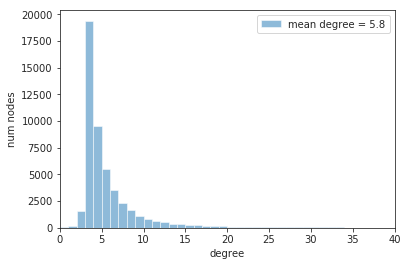

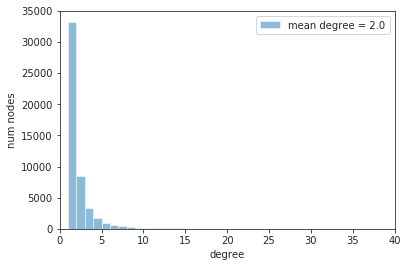

In [80]:
# Construct the network G
numNodes = 50000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=3)
# Baseline normal interactions:
G_norm     = models.custom_exponential_graph(baseGraph, scale=500)
models.plot_degree_distn(G_norm, max_degree=40)

# Construct the network G under social distancing
numNodes = 50000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=1)
# Baseline normal interactions:
G_dist     = models.custom_exponential_graph(baseGraph, scale=200000)
models.plot_degree_distn(G_dist, max_degree=40)

In [102]:
model = models.SEIRSNetworkModel(
                                 # network connectivty
                                 G = G_norm,
                                 p       = 0.51,
                                 # clinical parameters
                                 beta    = 0.03, 
                                 sigma   = 4.0,
                                 omega   = 1.5,
                                 zeta    = 0,
                                 a = 0.43, # probability of an asymptotic (supermild) infection
                                 m = 1-0.43, # probability of a mild infection
                                 h = 0.20, # probability of hospitalisation for a mild infection
                                 c = 2/3, # probability of hospitalisation in cohort
                                 mi = 1/6, # probability of hospitalisation in midcare
                                 da = 6.5, # days of infection when asymptomatic (supermild)
                                 dm = 6.5, # days of infection when mild
                                 dc = 7,
                                 dmi = 14,
                                 dICU = 14,
                                 dICUrec = 6,
                                 dmirec = 6,
                                 dhospital = 5, # days before reaching the hospital when heavy or critical
                                 m0 = 0.49, # mortality in ICU
                                 maxICU = 2000,
                                 # testing
                                 theta_S = 0,
                                 theta_E = 0,
                                 theta_A = 0,
                                 theta_M = 0,
                                 theta_R = 0,
                                 psi_FP = 0,
                                 psi_PP = 1,
                                 dq     = 14,                                 
                                 # back-tracking
                                 phi_S   = 0,
                                 phi_E   = 0,
                                 phi_I   = 0,
                                 phi_A   = 0,
                                 phi_R   = 0,
                                 # initial condition
                                 initN = 11.43e6, #results are extrapolated to entire population
                                 initE = 0,
                                 initI = 3,
                                 initA = 0, 
                                 initM = 0,
                                 initC = 0,
                                 initCmirec=0,
                                 initCicurec=0,
                                 initR = 0,
                                 initD = 0,
                                 initSQ = 0,
                                 initEQ = 0,
                                 initIQ = 0,
                                 initAQ = 0,
                                 initMQ = 0,
                                 initRQ = 0,
                                 # monte-carlo sampling
                                 monteCarlo = False,
                                 repeats = 1
                            )

#### Extract Sciensano data

In [103]:
[index,data] = model.obtainData()
ICUvect = np.transpose(data[0])
hospital = np.transpose(data[1])
print(ICUvect.shape)

(1, 57)


#### Altering an object variable after intialisation

After initialising our 'model' it is still possible to change variables using the following syntax.

In [107]:
model.beta = 0.50

#### Running your first simulation

A simulation is run by using the attribute function *sim*, which uses one argument, the simulation time T, as its input. 

In [110]:
y = model.sim(60)

t = 0.09
t = 10.09
t = 20.03
t = 30.01
t = 40.00
t = 50.01
t = 60.00


For advanced users: the numerical results of the simulation can be accessed directly be calling *object.X* or *object.sumX* where X is the name of the desired population pool. Both are numpy arrays. *Ojbect.X* is a 3D array of the following dimensions:
- x-dimension: number of age categories,
- y-dimesion: tN: total number of timesteps taken (one per day),
- z-dimension: n_samples: total number of monte-carlo simulations performed.

Object.sumX is a 2D array containing only the results summed over all age categorie and has the following dimensions,
- x-dimesion: tN: total number of timesteps taken (one per day),
- y-dimension: n_samples: total number of monte-carlo simulations performed.


#### Visualising the results

To quickly visualise simulation results, two attribute functions were created. The first function, *plotPopulationStatus*, visualises the number of susceptible, exposed, infected and recovered individuals in the population. The second function, *plotInfected*, by default visualises the number of heavily and critically infected individuals. Both functions require no user input to work but both have some optional arguments,

> plotPopulationStatus(filename),
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

> plotInfected(asymptotic, mild, filename),
> - asymptotic: set to *True* to include the supermild pool in the visualisation.
> - mild: set to *True* to include the mild pool in the visualisation.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

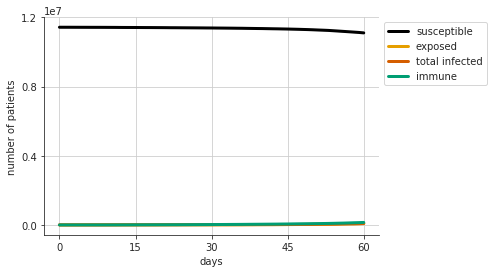

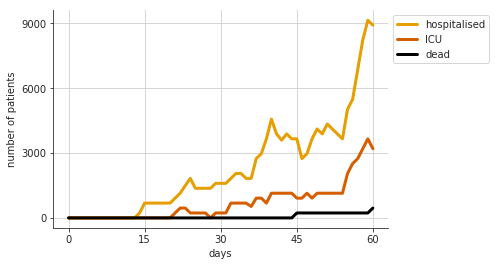

In [111]:
model.plotPopulationStatus()
model.plotInfected()

#### The use of checkpoints to change parameters on the fly

A cool feature of the original SEIRSplus package by Ryan McGee was the use of so-called *checkpoints* dictionary to change simulation parameters on the fly. In our modification, this feature is preserved. Below you can find an example of a *checkpoints* dictionary. The simulation will be started with the previously initialised parameters. After 40 days, social interaction will be limited by lowering the network connectivity to an average of 2 edges per node. The chance of random encounters is lowered to 10%. After 80 days, social restrictions are lifted and beta once more assumes its *business-as-usual* value. *checkpoints* is the only optional argument of the *sim* functions and is set to *None* per default.

t = 0.18
t = 10.05
t = 20.01
t = 30.01
t = 40.03
t = 50.00
[Checkpoint: Updating parameters]
t = 60.00
t = 70.02
t = 80.01
t = 0.04
t = 10.03
t = 20.42
t = 30.27
t = 0.04
t = 10.06
t = 20.27
t = 30.11
t = 40.62
t = 50.05
[Checkpoint: Updating parameters]
t = 60.28
t = 70.67


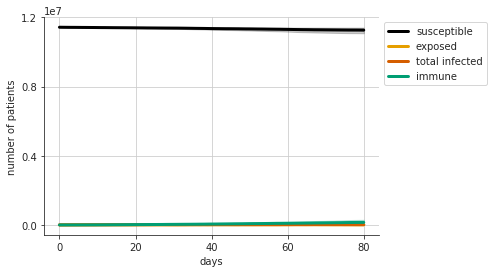

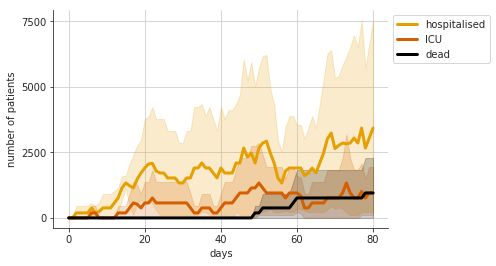

In [28]:
# Create checkpoints dictionary
chk = {'t':       [60], 
       'G':       [G_dist],
       'p':       [0.03],
      }
# Run simulation
y = model.sim(80,checkpoints=chk)
# Visualise
model.plotPopulationStatus()
model.plotInfected()

## Calibrating $\beta$  in a *business-as-usual* scenario ($N_c = 11.2$)

### Performing a least-squares fit

The 'SEIRSNetworkModel' class contains a function to fit the model to selected data (*fit*) and one function to visualise the result (*plotFit*). Our code uses the **genetic algorithm** from scipy to perform the optimisation. The *fit* function has the following basic syntax,

> sim(data, parNames, positions, bounds, weights)
> - data: a list containing the dataseries (dtype=np array) to fit the model to. For now, dataseries must be of equal length.
> - parNames: a list containing the names (dtype=string) of the model parameters to be fitted.
> - positions: a list containing the model states (dtype=np.array) used to calculate the sum of least squares. Each dataseries must be matched to a certain (sum of) model state(s). If multiple entries are provided these are added togheter. The order of the states is given according to the following vector, where S has index 0: (S, E, A, M, C, Mi, ICU, R, F, SQ, EQ, AQ, MQ, RQ).


The following arguments are optional,
> - checkpoints: checkpoint dictionary can be used to calibrate under specific scenarios such as policy changes (default: None).
> - setvar: True to replace fitted values in model object after fit is performed (default: False).
> - disp: Show sum-of-least-squares after each optimisation iteration (default: True).
> - polish: True to use a Nelder–Mead simplex to polish the final result (default: True).
> - maxiter: Maximum number of iterations (default: 30).
> - popsize: Population size of genetic algorithm (default: 10).

The genetic algorithm will by default use all cores available for the optimisation. Using the *fit* attribute, it is possible to calibrate any number of model parameters to any sets of data. We do note that fitting the parameters sm,m,h and c requires modification of the source code. In the example below, the transmission parameter $\beta$ is sought after using two dataseries. The first is the number of patients in need of intensive care and the second is the total number of people in the hospital. The number of patients in ICU is matched with the CH population pool while the number of hospitalisations is matched with the sum of the HH and CH population pools.

In [7]:
# vector with dates
index=pd.date_range('2020-03-15', freq='D', periods=ICUvect.size)
# data series used to calibrate model must be given to function 'plotFit' as a list
idx = -42
index = index[0:idx]
data=[np.transpose(ICUvect[:,0:idx]),np.transpose(hospital[:,0:idx])]
# set optimisation settings
parNames = ['beta','p'] # must be a list!
positions = [np.array([6]),np.array([4,5,6])] # must be a list!
bounds=[(1,100),(0.1,1),(0.1,1)] # must be a list!
weights = np.array([1,0])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,setvar=True,maxiter=1,popsize=1)

No constraints given.
t = 0.25
t = 10.18
t = 20.00
t = 30.00
t = 40.00
t = 50.01
t = 60.01
t = 0.09
t = 0.37
t = 10.13
t = 20.08
t = 30.01
t = 40.02
t = 50.01
t = 60.00
t = 20.38
t = 10.19
t = 20.00
t = 30.00
t = 40.01
t = 50.00
t = 60.10
t = 10.18
t = 20.02
t = 30.02
t = 40.03
t = 50.02
t = 60.01
t = 10.05
t = 20.01
t = 30.01
t = 40.01
t = 50.00
t = 60.06
t = 0.28
t = 10.13
t = 20.05
t = 30.00
t = 40.01
t = 50.00
t = 60.12
120161657732.18193
t = 0.23
t = 10.10
t = 20.02
t = 30.00
t = 40.02
t = 50.04
t = 60.02
t = 70.10
t = 80.01
t = 90.02
t = 10.54
t = 0.71
t = 10.02
t = 20.00
t = 30.00
t = 40.04
t = 50.03
t = 60.06
t = 70.24
t = 80.60
t = 90.30
t = 0.93
t = 10.05
t = 20.02
t = 30.00
t = 40.01
t = 50.01
t = 60.01
t = 70.07
t = 80.03
t = 100.28
t = 10.06
t = 20.03
t = 30.00
t = 40.01
t = 50.06
t = 60.02
t = 70.11
t = 80.25
t = 90.19
t = 100.29
t = 0.45
t = 10.38
t = 20.00
t = 30.00
t = 40.00
t = 50.03
t = 60.01
t = 70.29
t = 80.30
t = 90.40
t = 100.72
t = 0.37
13219528262.391066
New be

Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/twallema/anac

  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/models.py", line 1989, in run
    running = self.run_iteration()
KeyboardInterrupt
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/models.py", line 1874, in run_iteration
    propensities_flat   = propensities.ravel(order='F')
KeyboardInterrupt


KeyboardInterrupt: 

### Visualising the fit

Visualising the resulting fit is easy and can be done using the plotFit function. The functions uses the following basic syntax,

> plotFit(index,data,positions)
> - index: vector with timestamps corresponding to data.
> - data: list containing the dataseries (dtype=np array) to fit the model to. For now, dataseries must be of equal length.
> - positions: list containing the model states (dtype=np.array) used to calculate the sum of least squares.

The following arguments are optional,
> - dataMkr: list containing the markers (dtype=str) to be used to visualise the data. Default value works up to five dataseries and is equal to: ['o','v','s','*','^'].
>- modelClr: list containing the colors (dtype=str) to be used to visualise the model fit. Default value works up to five dateseries and is equal to: ['green','orange','red','black','blue'].
> - legendText: tuple containing the legend entries. Disabled per default.
> - titleText: string containing the fit title. Disable per default.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

t = 0.24
t = 20.07
t = 30.24
t = 40.08
t = 50.07
t = 60.01
t = 0.27
t = 10.31
t = 20.47
t = 30.30
t = 40.09
t = 50.06
t = 60.14
t = 0.62
t = 0.63
t = 20.61
t = 30.01
t = 40.17
t = 50.00
t = 60.01
t = 20.95
t = 30.11
t = 40.09
t = 60.56
t = 30.62
t = 40.17
t = 50.01
t = 60.13
t = 0.05
t = 10.27
t = 20.24
t = 30.04
t = 40.08
t = 50.05
t = 60.00
t = 20.56
t = 30.51
t = 40.13
t = 50.02
t = 60.02
t = 0.23


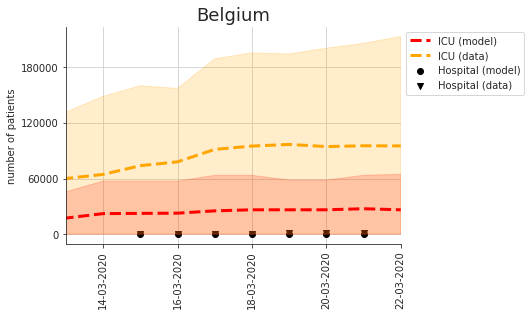

In [6]:
# plot result
model.plotFit(index,data,positions,modelClr=['red','orange'],legendText=('ICU (model)','ICU (data)','Hospital (model)','Hospital (data)'),titleText='Belgium')

# Code works untill here

To be continued...

## Model Predictive control (MPC)

### Optimising government policy

#### Process control for the layman

As we have the impression that the control part, which we see as our main addition to the problem, is more difficult to grasp for the layman, here is a short intro to process control. Experts in control are welcome to skip this section.

A predictive model consists of a set of equations and aims to predict how the system will behave in the future given a certain input. Process control flips this around and aims at determining what input is needed to achieve a desired system behavior (= goal). It is a tool that helps us in “controlling” how we want a system to behave. It is commonly applied in many industries, but also in our homes (e.g. central heating, washing machine). It's basically everywhere. Here's how it works. An algorithm monitors the deviation between the goal and the true system value and then computes the necessary action to "drive" the system to its goal by means of an actuator (in industry this is typically a pump or a valve). Applying this to Covid-19, the government wants to "control" the spread of the virus in the population by imposing measures (necessary control actions) on the public (which is the actuator here) and achieve the goal that the number of severely sick people does not become larger than can be handled by the health care system. However, the way the population behaves is a lot more complex compared to the heating control in our homes since not only epidemiology (virus spread) but also different aspects of human behavior on both the individual and the societal level (sociology, psychology, economy) are involved. This leads to multiple criteria we want to ideally control simultaneously and we want to use the "smartest" algorithm we can get our hands on.

#### The optimizePolicy function

The 'SEIRSNetworkModel' class contains an implementation of the MPC controller in the function *optimizePolicy*. For now, the controller minimises a weighted squared sum-of-errors between multiple setpoints and model predictions. The algorithm can use any variable to control the virus outbreak, but we recommend sticking with the number of random daily contacts $N_c$ and the total number of random tests ('totalTests') as only these have been tested. We also recommend disabling age-structuring in the model before running the MPC as this feature requires discretisation of the interaction matrix to work which is not yet implemented. Future work will extend the MPC controller to work with age-structuring feature inherent to the model. Future work is also aimed at including an economic cost function to discriminate between control handles. Our MPC uses the **genetic algorithm** from scipy.optimize to perform the optimisation, we recommend using at least a populationsize of 20 and at least 100 iterations to ensure that the trajectory is 'optimal'. The *optimizePolicy* function has the following basic syntax,

> optimizePolicy(parNames, bounds, setpoints, positions, weights)
> - parNames: a list containing the names (dtype=string) of the model parameters to be used as a control handle.
> - bounds: A list containing the lower- and upper boundaries of each parameter to be used as a control handle. Each entry in the list should be a 1D numpy array containing the lower- and upper bound for the respective control handle.
> - setpoints: A list with the numerical values of the desired model output.
> - positions: a list containing the model states (dtype=np.array) used to calculate the sum of least squares. Each modelouput in the given position is matched with a provided setpoint. If multiple position entries are provided, the output in these positions is added togheter. The order of the states is given according to the following vector, where S has index 0: (S, E, A, M, C, Mi, ICU, R, F, SQ, EQ, AQ, MQ, RQ).


The following arguments are optional,
> - policy_period: length of one policy interval (default: 7 days).
> - N: number of future policy intervals to be optimised, also called 'control horizon' (default: 6).
> - P: number of policy intervals over which the sum of squared errors is calculated, also called 'prediction horizon' (default:12).
> - disp: Show sum-of-least-squares after each optimisation iteration (default: True).
> - polish: True to use a Nelder–Mead simplex to polish the final result (default: True).
> - maxiter: Maximum number of iterations (default: 100).
> - popsize: Population size of genetic algorithm (default: 20).

The function returns a one-dimensional list containing the optimal values of the control handles. The length of this list is equal to the length of the control horizon (N) times the number of control handles. The list thus lists all control handles and their optimal values in their respective order. **The optimal policy is assigned to the SEIRSNetworkModel object and is only overwritten when a new optimisation is performed. Future work could include the creation of a new object for every optimal policy.** The genetic algorithm will by default use all cores available for the optimisation.

In [ ]:
parNames = ['Nc','totalTests']
bounds = [np.array([0,11.2]),np.array([0,1e6])]
setpoints = [1200,5000]
positions = [np.array([7]),np.array([6,7])]
weights = [1,0]
model.optimizePolicy(parNames,bounds,setpoints,positions,weights,policy_period=30,N=6,P=12,polish=False,maxiter=1,popsize=10)

### Visualising the effect of government policy

Visualising the resulting optimal policy is easy and can be done using the plotOptimalPolicy function. We note that the functionality of*plotOptimalPolicy** is for now, very basic and will be extended in the future. The function is heavily based on the *plotInfected* visualisation. The function uses the following basic syntax,

> plotOptimalPolicy(parNames,setpoints,policy_period)
> - parNames: a list containing the names (dtype=string) of the model parameters to be used as a control handle.
> - setpoints: A list with the numerical values of the desired model output.
> - policy_period: length of one policy interval (default: 7 days).

The following arguments are optional,
> - asymptotic: set to *True* to include the supermild pool in the visualisation.
> - mild: set to *True* to include the mild pool in the visualisation.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

In [ ]:
model.plotOptimalPolicy(parNames,setpoints,policy_period=14)

## Scenario-specific extensions

### *realTimeScenario*

The 'SEIRSNetworkModel' class contains one function to quickly perform and visualise scenario analysis for a given country. The user is obligated to supply the function with: 1) a set of dataseries, 2) the date at which the data starts, 3) the positions in the model output that correspond with the dataseries and 4) a checkpoints dictionary containing the past governement actions, from hereon referred to as the *pastPolicy* dictionary. If no additional arguments are provided, the data and the corresponding model fit are visualised from the user supplied start date up until the end date of the data plus 14 days. The end date of the visualisation can be altered by defining the optional keyworded argument *T_extra* (default: 14 days). Optionally a dictionary of future policies can be used to simulate scenarios starting on the first day after the end date of the dataseries. The function *realTimeScenario* accomplishes this by merging both the *pastPolicy* and *futurePolicy* dictionaries using the backend function *mergeDict()*. The syntax without optional arguments is as follows,

> realTimeScenario(startDate, data, positions, pastPolicy)
> - startDate: a string with the date corresponding to the first entry of the dataseries (format: 'YYYY-MM-DD'). 
> - data: a list containing the dataseries (dtype=np array) to fit the model to. For now, dataseries must be of equal length and start on the same day.
> - positions: a list containing the model states (dtype=np.array) used to calculate the sum of least squares. Each dataseries must be matched to a certain (sum of) model state(s). If multiple entries are provided these are added togheter. The order of the states is given according to the following vector, where S has index 0: (S, E, A, M, C, Mi, ICU, R, F, SQ, EQ, AQ, MQ, RQ).
> - pastPolicy: a checkpoints dictionary containing past government actions.

The following (simulation) arguments are optional,
> - futurePolicy: a checkpoint dictionary used to simulate scenarios in the future (default: None). By default, time '1' in this dictionary is the date of the first day after the end of the data.
> - T_extra: Extra simulation time after last date of the data if no futurePolicy dictionary is provided. Extra simulation time after last time in futurePolicy dictionary.

The following arguments are for visualisation,
> - dataMkr: list containing the markers (dtype=str) to be used to visualise the data. Default value works up to five dataseries and is equal to: ['o','v','s','*','^'].
>- modelClr: list containing the colors (dtype=str) to be used to visualise the model fit. Default value works up to five dateseries and is equal to: ['green','orange','red','black','blue'].
> - legendText: tuple containing the legend entries. Disabled per default.
> - titleText: string containing the fit title. Disable per default.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICUvect),np.transpose(hospital)]
# Create a dictionary of past policies
pastPolicy = {'t':       [11], 
              'G':       [G_dist],
              'p':       [0.03]
              }
# Create a dictionary of future policies
futurePolicy = {'t':     [1], 
              'G':       [G_norm],
              'p':       [0.6]
              }
# Define the data corresponding to the first data entry
startDate='2020-03-13'
# Run realTimeScenario
model.realTimeScenario(startDate,data,positions,pastPolicy,futurePolicy=futurePolicy,T_extra=7,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium')